## Imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings

## Pregunta 1

* Cargue la base de datos Lluvia_full.csv
* Codifique la variable LluviaMan como 0 y 1 para los días sin lluvia y con lluvia respectivamente.
* Realice una separación de la base de datos en un set de entrenamiento y set de validación. Utilice una proporción de 70:30 respectivamente estratificado por la LluviaMan.
* Fije una semilla antes de obtener los indices. Para ello utilice la función set.seed(2023).

In [3]:
url1 = 'https://raw.githubusercontent.com/louisboza/DS_UC_Diplomado/main/Taller_2/scr/Lluvia_full.csv'
df = pd.read_csv(url1)

In [5]:
df.head(5)

,MinTemp,MaxTemp,Lluvia,Evaporacion,Sol,VelRafaga,Vel9am,Vel3pm,Hum9am,Hum3pm,Pres9am,Pre3pm,Nub9am,Nub3pm,Temp9am,Temp3pm,LluviaHoy,LluviaMan,Koppen,Estacion
0,7.6,19.3,0.0,3.4,9.4,35.0,13.0,13.0,73.0,32.0,1018.6,1015.4,1.0,1.0,9.4,18.8,No,No,Subtropical,Invierno
1,6.8,19.5,0.0,3.4,9.4,46.0,19.0,28.0,67.0,42.0,1018.4,1015.2,1.0,1.0,11.9,17.9,No,No,Subtropical,Invierno
2,5.5,13.9,0.0,2.8,3.8,44.0,26.0,13.0,72.0,58.0,1017.8,1015.5,7.0,7.0,8.1,12.2,No,No,Temperate,Invierno
3,8.6,14.3,0.0,2.8,3.8,35.0,13.0,17.0,67.0,56.0,1017.4,1015.0,7.0,7.0,9.3,13.4,No,Yes,Temperate,Invierno
4,7.9,13.0,0.0,2.8,3.8,39.0,15.0,17.0,68.0,69.0,1017.6,1015.3,7.0,7.0,9.0,11.7,No,No,Temperate,Invierno


In [7]:
df['LluviaMan_code'] = np.where(df['LluviaMan'] == "No", 0, 1)

In [14]:
from sklearn.model_selection import train_test_split

X = df.drop(['LluviaMan', 'LluviaMan_code'], axis = 1)
y = df['LluviaMan_code']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2023, stratify = y)

## Pregunta 2

1. Utilizando el set de entrenamiento, ajuste un modelo de regresión logística, SVM, árbol de clasificación y Random Forest. Para ello debe:

* Limpiar los datos - Escalar los datos numéricos. - Transformar a dummys las variables categóricas.

2. Definir la grilla de hiperparámetros a optimizar, en este caso:

SVM
* Costo

Árbol de clasificación:
* Observaciones mínimas para división.
* Costo de complejidad.
* Profundidad máxima del árbol.

Random Forest
* Número de árboles.
* Número de predictores muestreados para cada árbol.
* Observaciones mínimas para división.

3. Buscar los hiperparámetros óptimos utilizando validación cruzada optimizando la métrica de roc_auc

In [11]:
df.dtypes

MinTemp           float64
MaxTemp           float64
Lluvia            float64
Evaporacion       float64
Sol               float64
VelRafaga         float64
Vel9am            float64
Vel3pm            float64
Hum9am            float64
Hum3pm            float64
Pres9am           float64
Pre3pm            float64
Nub9am            float64
Nub3pm            float64
Temp9am           float64
Temp3pm           float64
LluviaHoy          object
LluviaMan          object
Koppen             object
Estacion           object
LluviaMan_code      int64
dtype: object

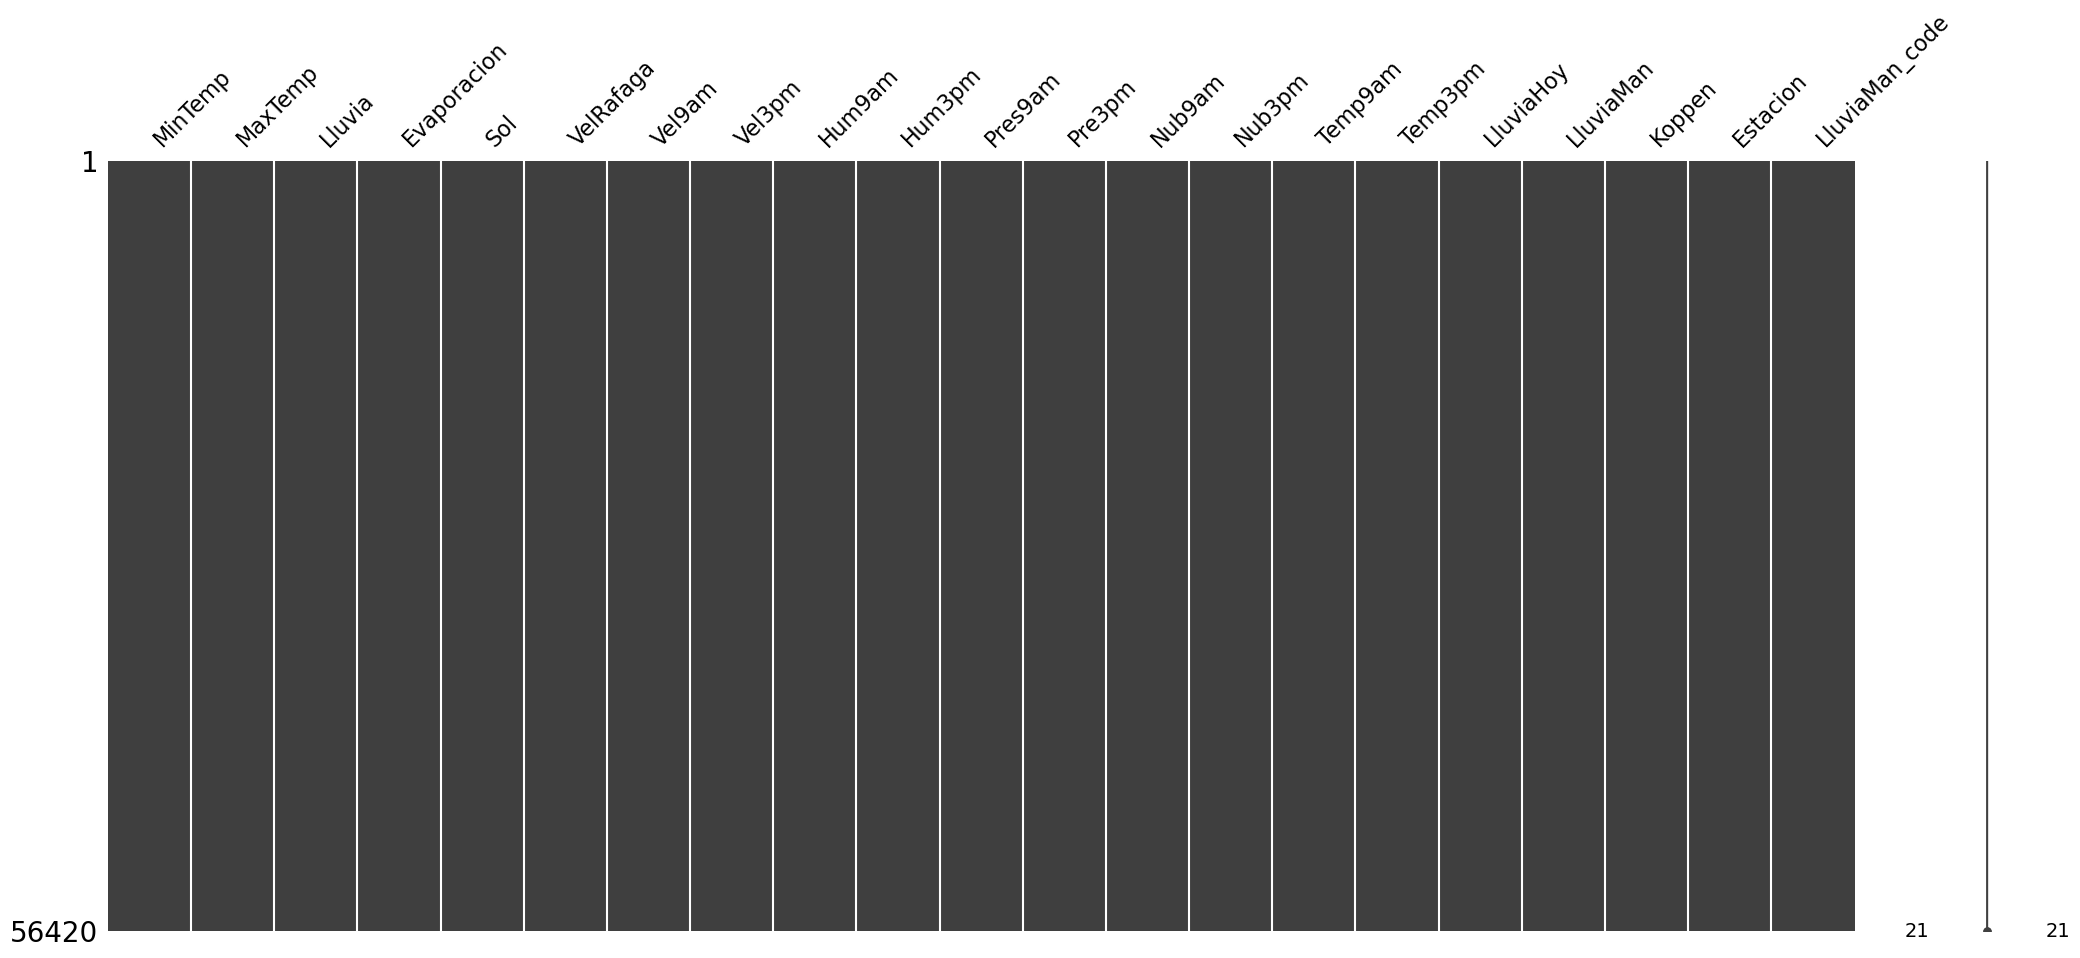

In [13]:
msno.matrix(df)
plt.show();

La base se ve estable, sin valores nulos.

In [16]:
cat_var = X_train.columns[X_train.dtypes=='object']
num_var = X_train.columns[X_train.dtypes!='object']

In [20]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

onehot = OneHotEncoder()
scaler = StandardScaler()

transformer = make_column_transformer(
        (scaler, num_var),
        (onehot, cat_var),
        remainder                 = 'passthrough',
        verbose_feature_names_out = False
)

transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 Index(['MinTemp', 'MaxTemp', 'Lluvia', 'Evaporacion', 'Sol', 'VelRafaga',
       'Vel9am', 'Vel3pm', 'Hum9am', 'Hum3pm', 'Pres9am', 'Pre3pm', 'Nub9am',
       'Nub3pm', 'Temp9am', 'Temp3pm'],
      dtype='object')),
                                ('onehotencoder', OneHotEncoder(),
                                 Index(['LluviaHoy', 'Koppen', 'Estacion'], dtype='object'))],
                  verbose_feature_names_out=False)

In [21]:
X_train_prep = pd.DataFrame(
        data = transformer.transform(X_train),
        columns = transformer.get_feature_names_out()
)

X_test_prep = pd.DataFrame(
        data = transformer.transform(X_test),
        columns = transformer.get_feature_names_out()
)

## Regresión logística

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import RocCurveDisplay

Features = ['No Lluvia', 'Lluvia']

def mostrar_resultados(y_test, y_pred, X_test_prep, model):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (6, 6))
    sns.heatmap(conf_matrix, xticklabels = Features, yticklabels = Features, annot = True, fmt = "d")
    plt.title("Matriz de confusion")
    plt.ylabel("Valores reales")
    plt.xlabel("Predicciones")
    plt.show()
    fig, ax = plt.subplots(figsize = (8,6))
    RocCurveDisplay.from_estimator(
        estimator = model,
        X = X_test_prep,
        y = y_test,
        ax = ax
    )
    
    ax.plot([0,1],ls = '--')
    ax.set_title("ROC")
    print(f'Reporte de clasificación:\n{classification_report(y_test,y_pred)}')

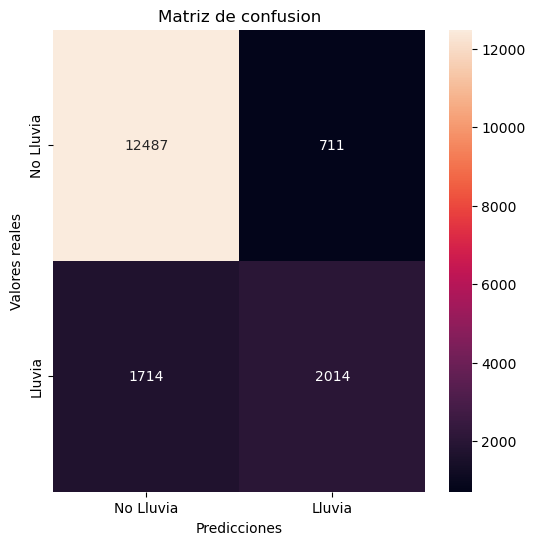

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     13198
           1       0.74      0.54      0.62      3728

    accuracy                           0.86     16926
   macro avg       0.81      0.74      0.77     16926
weighted avg       0.85      0.86      0.85     16926



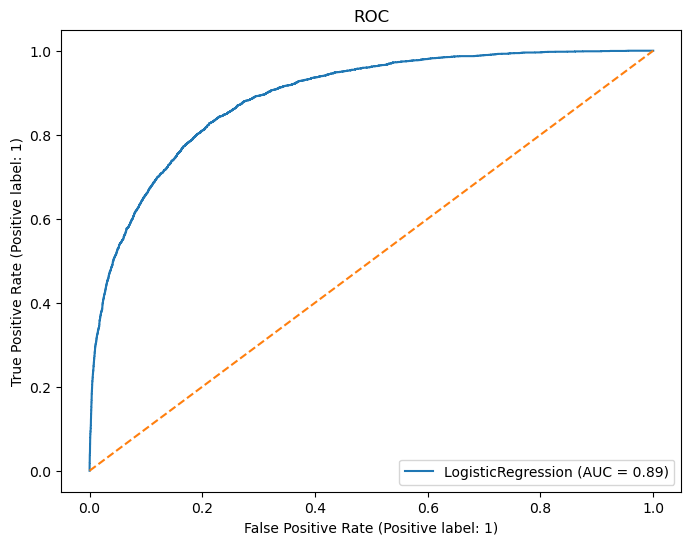

In [50]:
from sklearn.linear_model import LogisticRegression

logic = LogisticRegression(max_iter = 10000)
logic.fit(X_train_prep, y_train)
y_log_pred = logic.predict(X_test_prep)
mostrar_resultados(y_test, y_log_pred, X_test_prep, logic)

## SVM

In [28]:
from sklearn.svm import SVC 
from mlxtend.plotting import plot_decision_regions

svm = SVC(random_state = 2023)
svm.fit(X_train_prep, y_train)

SVC(random_state=2023)

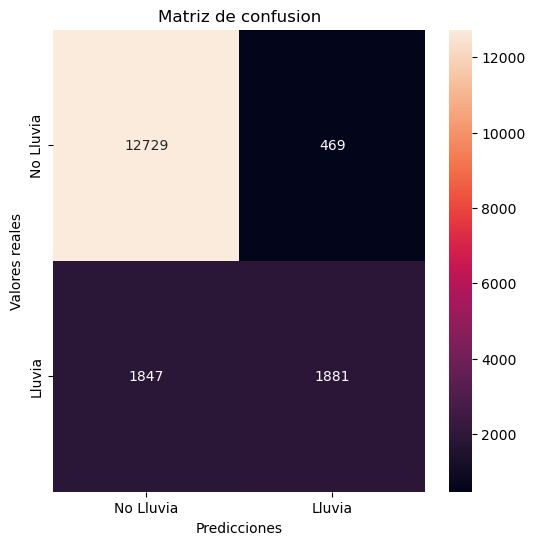

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.96      0.92     13198
           1       0.80      0.50      0.62      3728

    accuracy                           0.86     16926
   macro avg       0.84      0.73      0.77     16926
weighted avg       0.86      0.86      0.85     16926



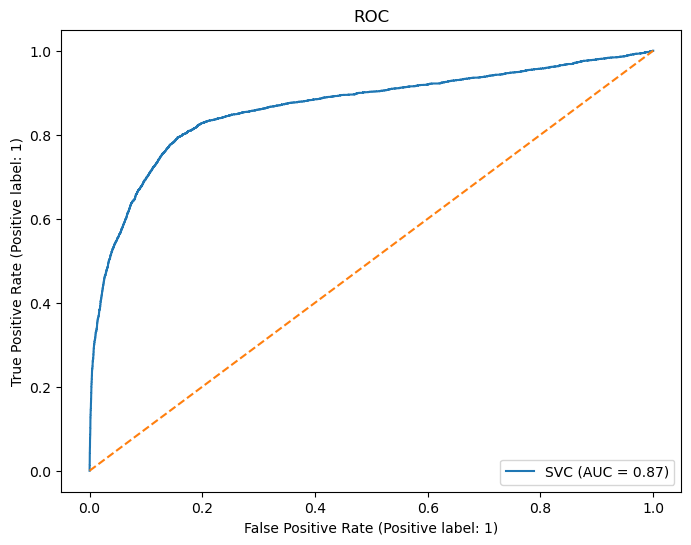

In [29]:
y_svm_pred = svm.predict(X_test_prep)
mostrar_resultados(y_test, y_svm_pred, X_test_prep, svm)

In [30]:
from sklearn.model_selection import GridSearchCV, KFold

hiperparametros = {"kernel" : ["rbf", "linear", "poly"],
                   "C": np.logspace(-4, 1, 15)}

config = KFold(n_splits = 5, shuffle = True, random_state = 2023)
modelo = SVC(random_state = 2023)

modelos = GridSearchCV(
    estimator  = modelo,
    param_grid = hiperparametros,
    cv         = config,
    scoring    = 'roc_auc',
    n_jobs     = -1 ,
    verbose    = 1
)

modelos.fit(X_train_prep, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=2023, shuffle=True),
             estimator=SVC(random_state=2023), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.27584593e-04, 5.17947468e-04, 1.17876863e-03,
       2.68269580e-03, 6.10540230e-03, 1.38949549e-02, 3.16227766e-02,
       7.19685673e-02, 1.63789371e-01, 3.72759372e-01, 8.48342898e-01,
       1.93069773e+00, 4.39397056e+00, 1.00000000e+01]),
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring='roc_auc', verbose=1)

In [31]:
print(modelos.best_params_)

{'C': 0.013894954943731374, 'kernel': 'linear'}


In [32]:
svm_2 = modelos.best_estimator_.fit(X_train_prep, y_train)

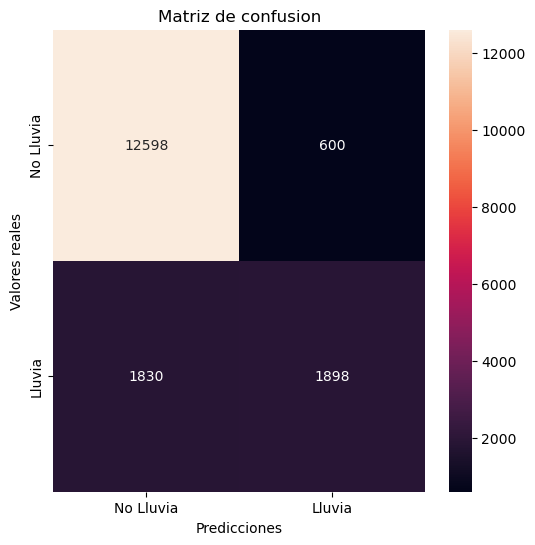

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     13198
           1       0.76      0.51      0.61      3728

    accuracy                           0.86     16926
   macro avg       0.82      0.73      0.76     16926
weighted avg       0.85      0.86      0.85     16926



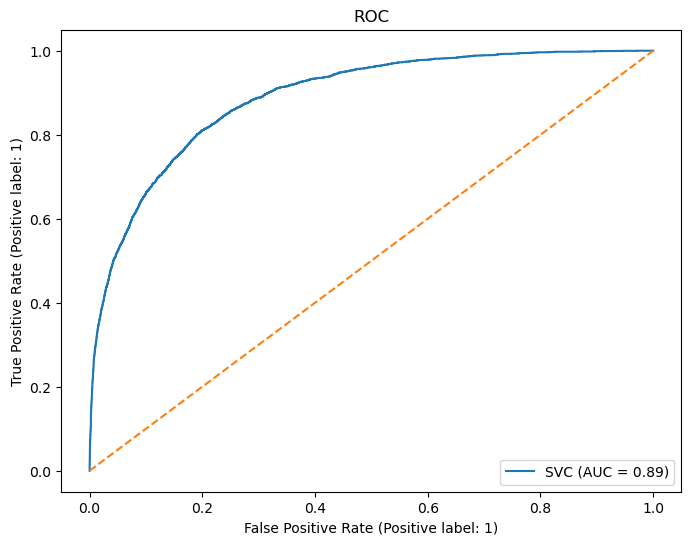

In [33]:
y_svm_pred_2 = svm_2.predict(X_test_prep)
mostrar_resultados(y_test, y_svm_pred_2, X_test_prep, svm_2)

## Decision Tree Classifier

In [34]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state = 2023)
clf.fit(X_train_prep, y_train)

DecisionTreeClassifier(random_state=2023)

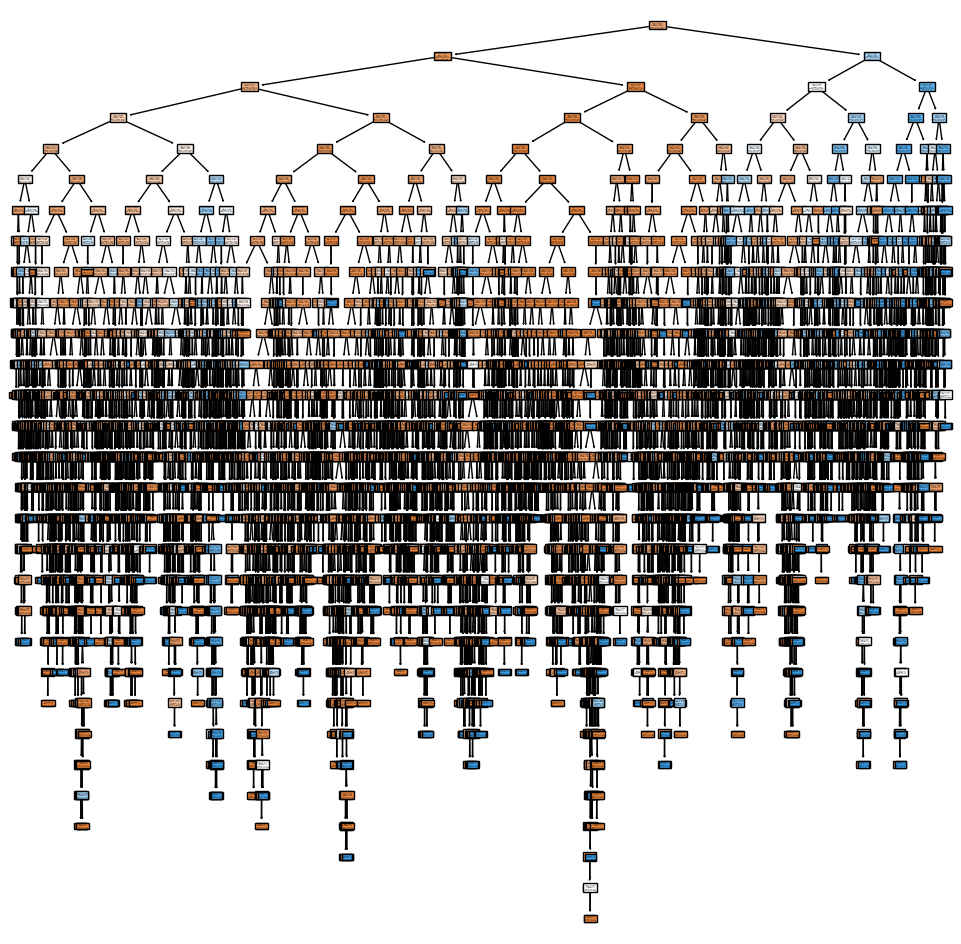

In [35]:
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import plot_tree
from sklearn import tree

fig, ax = plt.subplots(figsize = (12, 12))
plot_tree(clf, filled = True, class_names = Features);

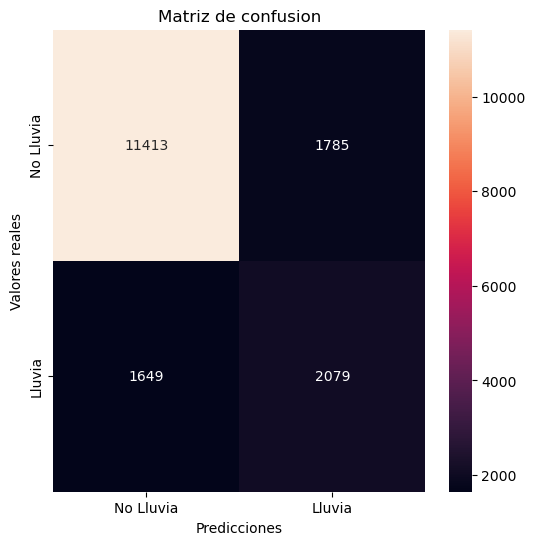

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     13198
           1       0.54      0.56      0.55      3728

    accuracy                           0.80     16926
   macro avg       0.71      0.71      0.71     16926
weighted avg       0.80      0.80      0.80     16926



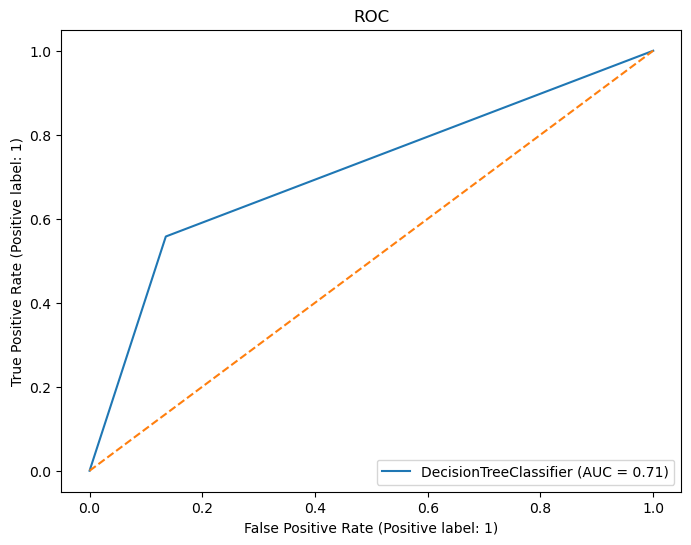

In [36]:
y_clf_pred = clf.predict(X_test_prep)
mostrar_resultados(y_test, y_clf_pred, X_test_prep, clf)

In [37]:
from sklearn.model_selection import GridSearchCV, KFold

hiperparametros = {'criterion': ['gini', 'entropy'],
                   'max_depth': np.arange(2, 10), #Profundidad del arbol
                   'ccp_alpha': np.logspace(-6, 1, 15), #Costo de complejidad
                   'min_samples_split': [2, 5, 10, 20, 50]#Observaciones minimas para la división
                   }

configuraciones= KFold(n_splits = 5, shuffle = True, random_state = 2023)
modelo = DecisionTreeClassifier(random_state = 2023)

modelos = GridSearchCV(
    estimator  = modelo,
    param_grid = hiperparametros,
    cv         = configuraciones,
    scoring    = 'roc_auc',
    n_jobs     = -1,
    verbose    = 1
)

modelos.fit(X_train_prep, y_train)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=2023, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=2023), n_jobs=-1,
             param_grid={'ccp_alpha': array([1.00000000e-06, 3.16227766e-06, 1.00000000e-05, 3.16227766e-05,
       1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01]),
                         'criterion': ['gini', 'entropy'],
                         'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_split': [2, 5, 10, 20, 50]},
             scoring='roc_auc', verbose=1)

In [38]:
modelos.best_params_

{'ccp_alpha': 0.00031622776601683794,
 'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_split': 50}

In [39]:
clf_2 = modelos.best_estimator_
clf_2.fit(X_train_prep, y_train)

DecisionTreeClassifier(ccp_alpha=0.00031622776601683794, criterion='entropy',
                       max_depth=8, min_samples_split=50, random_state=2023)

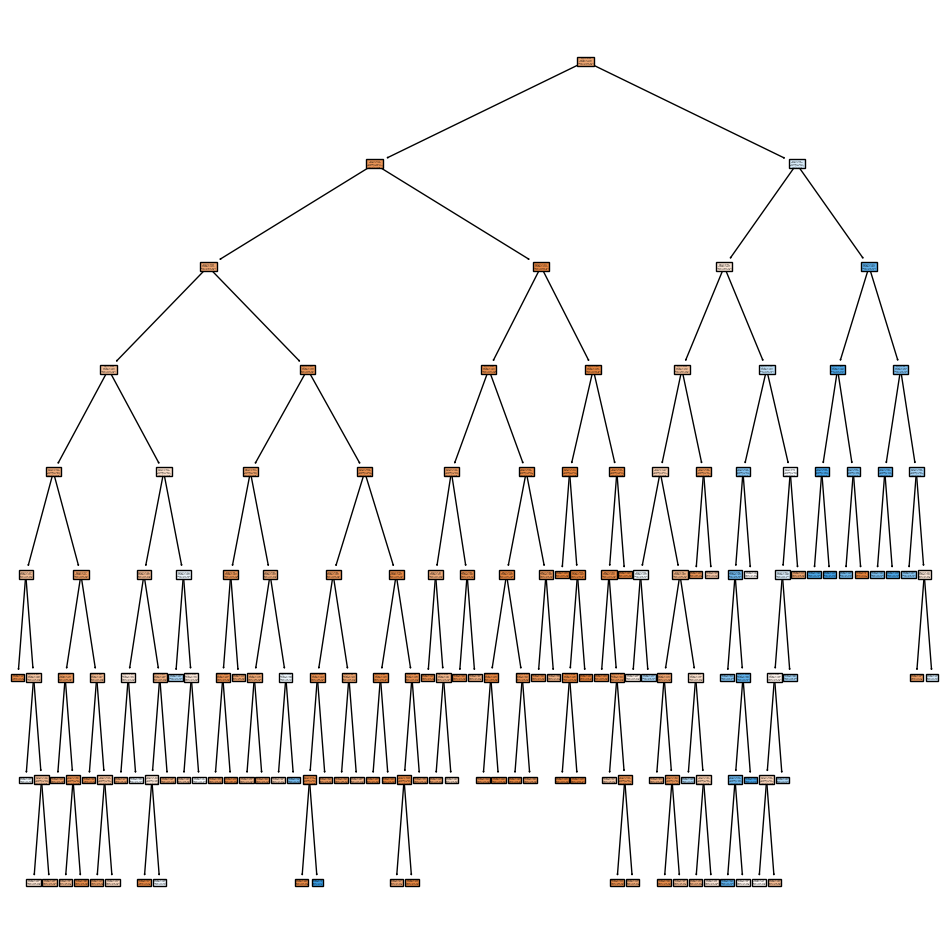

In [40]:
fig, ax = plt.subplots(figsize = (12,12))
plot_tree(clf_2, filled = True, class_names = Features);

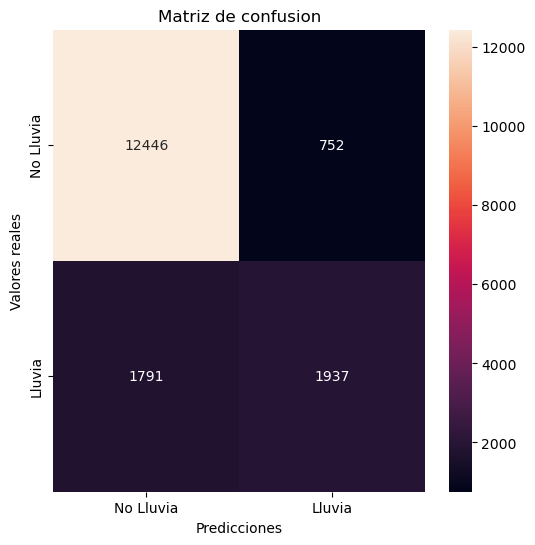

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91     13198
           1       0.72      0.52      0.60      3728

    accuracy                           0.85     16926
   macro avg       0.80      0.73      0.76     16926
weighted avg       0.84      0.85      0.84     16926



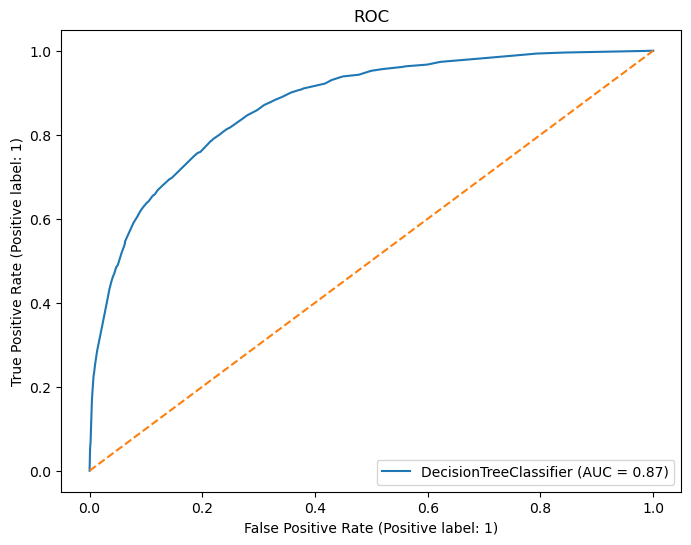

In [49]:
y_clf_pred_2 = clf_2.predict(X_test_prep)
mostrar_resultados(y_test, y_clf_pred_2, X_test_prep, clf_2)

## Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

Rf = RandomForestClassifier(random_state = 2023)
Rf.fit(X_train_prep, y_train)

RandomForestClassifier(random_state=2023)

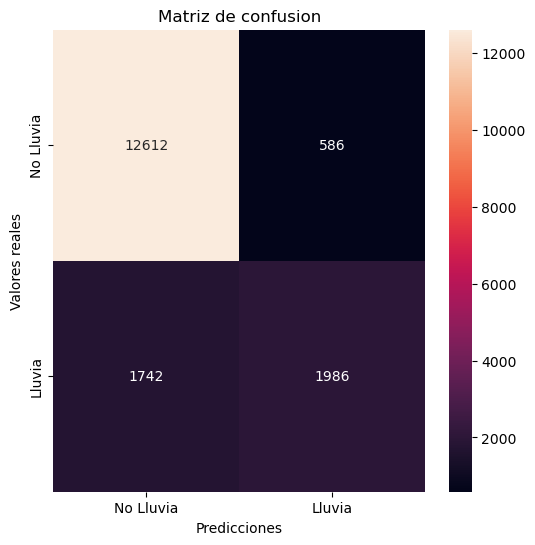

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     13198
           1       0.77      0.53      0.63      3728

    accuracy                           0.86     16926
   macro avg       0.83      0.74      0.77     16926
weighted avg       0.86      0.86      0.85     16926



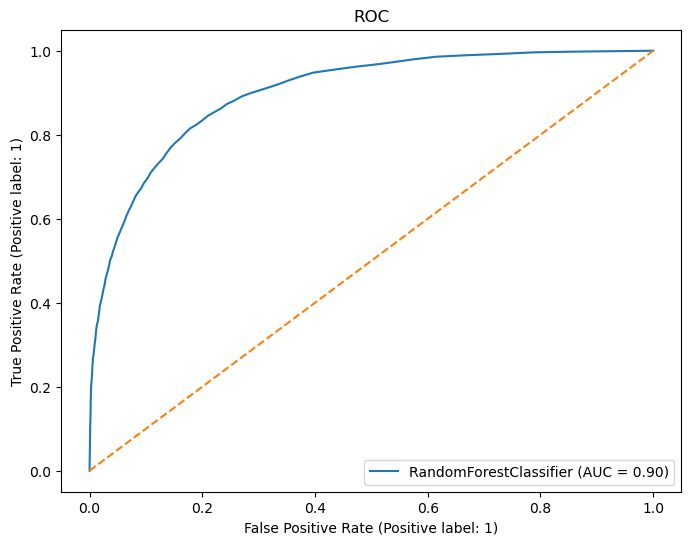

In [43]:
y_Rf_prep = Rf.predict(X_test_prep)
mostrar_resultados(y_test, y_Rf_prep, X_test_prep, Rf)

In [44]:
features_importance = pd.Series(Rf.feature_importances_,
                          index = X_train_prep.columns).sort_values(ascending = False)
features_importance

Hum3pm                0.171682
Sol                   0.101650
Pre3pm                0.070381
Pres9am               0.063562
VelRafaga             0.056083
Hum9am                0.052236
Nub3pm                0.051453
Temp3pm               0.046481
MinTemp               0.045540
Temp9am               0.044367
MaxTemp               0.043775
Lluvia                0.041690
Evaporacion           0.041337
Vel3pm                0.034329
Vel9am                0.033302
Nub9am                0.030981
LluviaHoy_No          0.018656
LluviaHoy_Yes         0.014266
Koppen_Subtropical    0.007490
Koppen_Temperate      0.006554
Estacion_Primavera    0.006082
Estacion_Otoño        0.005813
Estacion_Verano       0.004767
Estacion_Invierno     0.004487
Koppen_Grassland      0.002157
Koppen_Desert         0.000879
dtype: float64

In [45]:
hiperparametros = {'n_estimators': [50, 100, 200], 
                   'max_features': [0.1, 0.3, 0.5, 0.7, 0.9], 
                   'min_samples_split': [2, 5, 10, 20, 50, 100, 200]
                   }

config = KFold(n_splits = 10, shuffle = True, random_state = 2023)
model = RandomForestClassifier(random_state = 2023)

modelos = GridSearchCV(
    estimator  = model,
    param_grid = hiperparametros,
    cv         = config,
    scoring    = 'roc_auc',
    n_jobs     = -1,
    verbose    = 1
)
modelos.fit(X_train_prep, y_train)

Fitting 10 folds for each of 105 candidates, totalling 1050 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=2023, shuffle=True),
             estimator=RandomForestClassifier(random_state=2023), n_jobs=-1,
             param_grid={'max_features': [0.1, 0.3, 0.5, 0.7, 0.9],
                         'min_samples_split': [2, 5, 10, 20, 50, 100, 200],
                         'n_estimators': [50, 100, 200]},
             scoring='roc_auc', verbose=1)

In [46]:
modelos.best_params_

{'max_features': 0.3, 'min_samples_split': 5, 'n_estimators': 200}

In [47]:
Rf_2 = modelos.best_estimator_
Rf_2.fit(X_train_prep,y_train)

RandomForestClassifier(max_features=0.3, min_samples_split=5, n_estimators=200,
                       random_state=2023)

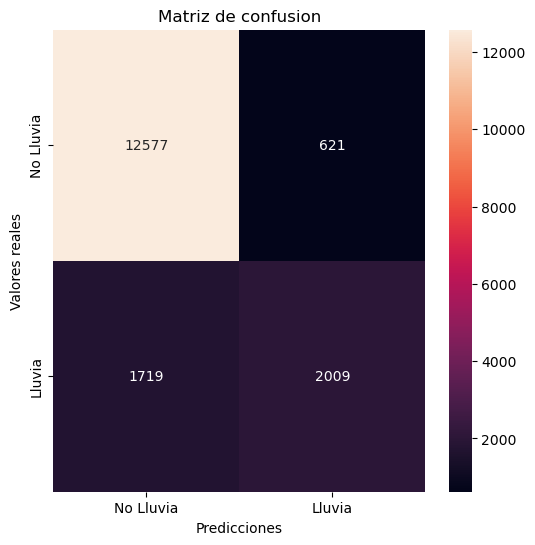

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     13198
           1       0.76      0.54      0.63      3728

    accuracy                           0.86     16926
   macro avg       0.82      0.75      0.77     16926
weighted avg       0.85      0.86      0.85     16926



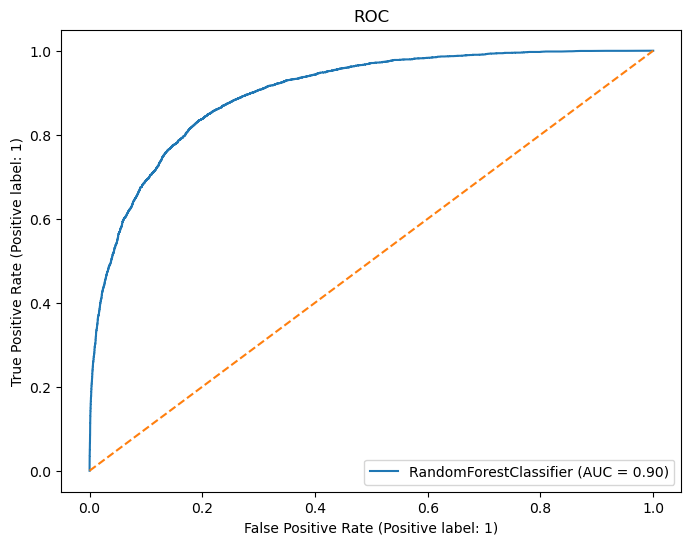

In [48]:
y_Rf_prep_2 = Rf_2.predict(X_test_prep)
mostrar_resultados(y_test, y_Rf_prep_2, X_test_prep, Rf_2)

## Pregunta 3

Compare los modelos ajustados utilizando el set de test, bajo el criterio de f1-score, ¿cuál es el mejor modelo en su caso?

In [53]:
F1Score_Raw = [['Logistic Model', 0.62], ['SVM', 0.61], ['Decision Tree Classifier', 0.60], ['Random Forest', 0.63]]
F1Score_df = pd.DataFrame(F1Score_Raw, columns=['Model', 'F1_Score'])

F1Score_df

,Model,F1_Score
0,Logistic Model,0.62
1,SVM,0.61
2,Decision Tree Classifier,0.60
3,Random Forest,0.63


El mejor modelo es Random Forest, puesto que el objentivo es predecir si lloverá al dia siguiente, y este modelo entrega un F1_Score de 0.63 en el caso de predecir la casuistica en cuestión.